<a href="https://colab.research.google.com/github/Ankita5051/DL-lab/blob/main/Facial_Expression_Recognition_with_CNN%2C_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub


In [ ]:
#import libraries
import kagglehub
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# **Task 1**
## Load the FER-2013 dataset from torchvision (train and test split). If torchvision does not contain the complete dataset, download it from Kaggle in .csv format: FER-2013 Dataset. Ensure proper preprocessing and normalization of the dataset.

In [ ]:
# Download the dataset
path = kagglehub.dataset_download("ninamustwin/fer2013")

print("Path to dataset files:", path)

# Locate the fer2013.csv file
root_dir = os.path.dirname(path)
csv_path = None
for root, dirs, files in os.walk(root_dir):
  if 'fer2013.csv' in files:
    csv_path = os.path.join(root, 'fer2013.csv')
    break

if csv_path is None:
  raise FileNotFoundError("The fer2013.csv file was not found in the downloaded dataset.")

# Load the dataset
def load_fer2013(csv_path):
  fer2013_df = pd.read_csv(csv_path)

  # Convert pixel strings to images
  def convert_to_image(pixels):
    pixels = np.array(pixels.split(), dtype='uint8').reshape((48, 48))
    return Image.fromarray(pixels)

  fer2013_df['pixels'] = fer2013_df['pixels'].apply(convert_to_image)

  # Split data into train and test sets based on 'Usage'
  train_df = fer2013_df[fer2013_df['Usage'] == 'Training']
  test_df = fer2013_df[fer2013_df['Usage'].isin(['PublicTest', 'PrivateTest'])]

  return train_df, test_df

# Load the dataset
train_df, test_df = load_fer2013(csv_path)

# Define a custom dataset class
class FER2013Dataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image = self.df.iloc[idx]['pixels']
    label = self.df.iloc[idx]['emotion']

    if self.transform is not None:
      image = self.transform(image)

    return image, label

# Define data transforms
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Create dataset instances
train_dataset = FER2013Dataset(train_df, transform=transform)
test_dataset = FER2013Dataset(test_df, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("dataset loaded successfully!")
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

100%|██████████| 96.6M/96.6M [00:00<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ninamustwin/fer2013/versions/1


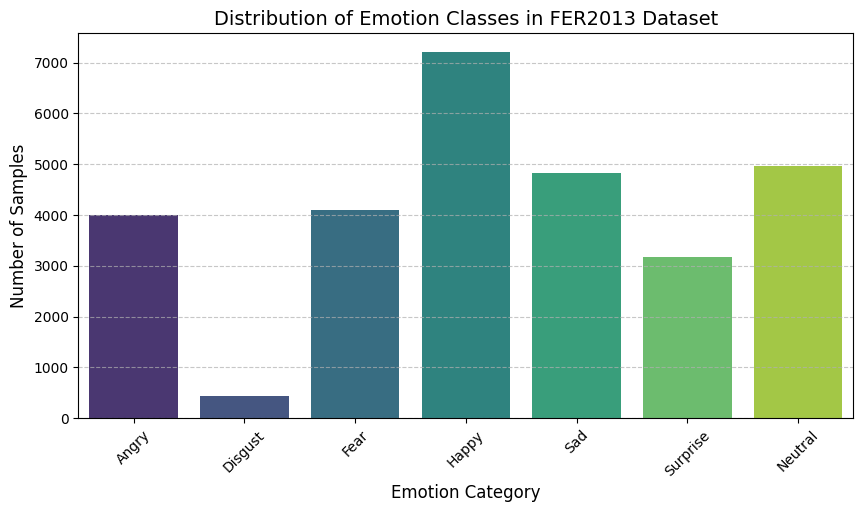

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use the train_df DataFrame instead of 'data'
emotion_counts = train_df['emotion'].value_counts().sort_index()

# Define emotion labels (FER2013 dataset uses these classes)
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

# Convert numerical labels to emotion names
emotion_names = [emotion_labels[idx] for idx in emotion_counts.index]

# Plot bar chart
plt.figure(figsize=(10,5))
sns.barplot(x=emotion_names, y=emotion_counts.values, hue=emotion_names, palette='viridis', legend=False)

# Labeling
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Emotion Classes in FER2013 Dataset', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# **Task 2**
## Divide the train split into training and validation partitions. Ensure randomness in the split to avoid bias. Define corresponding dataloaders for each partition to facilitate batch-wise data loading

In [ ]:
# Split the train data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
from sklearn.model_selection import train_test_split

# Split the train data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
# Create dataset instances for training and validation
val_dataset = FER2013Dataset(val_data, transform=transform)

# Create data loaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Training samples: 28709
Validation samples: 5742
Test samples: 7178


# **Task 3**
## Visualize the dataset by displaying 3 randomly selected samples from each class. Ensure labels are correctly assigned.

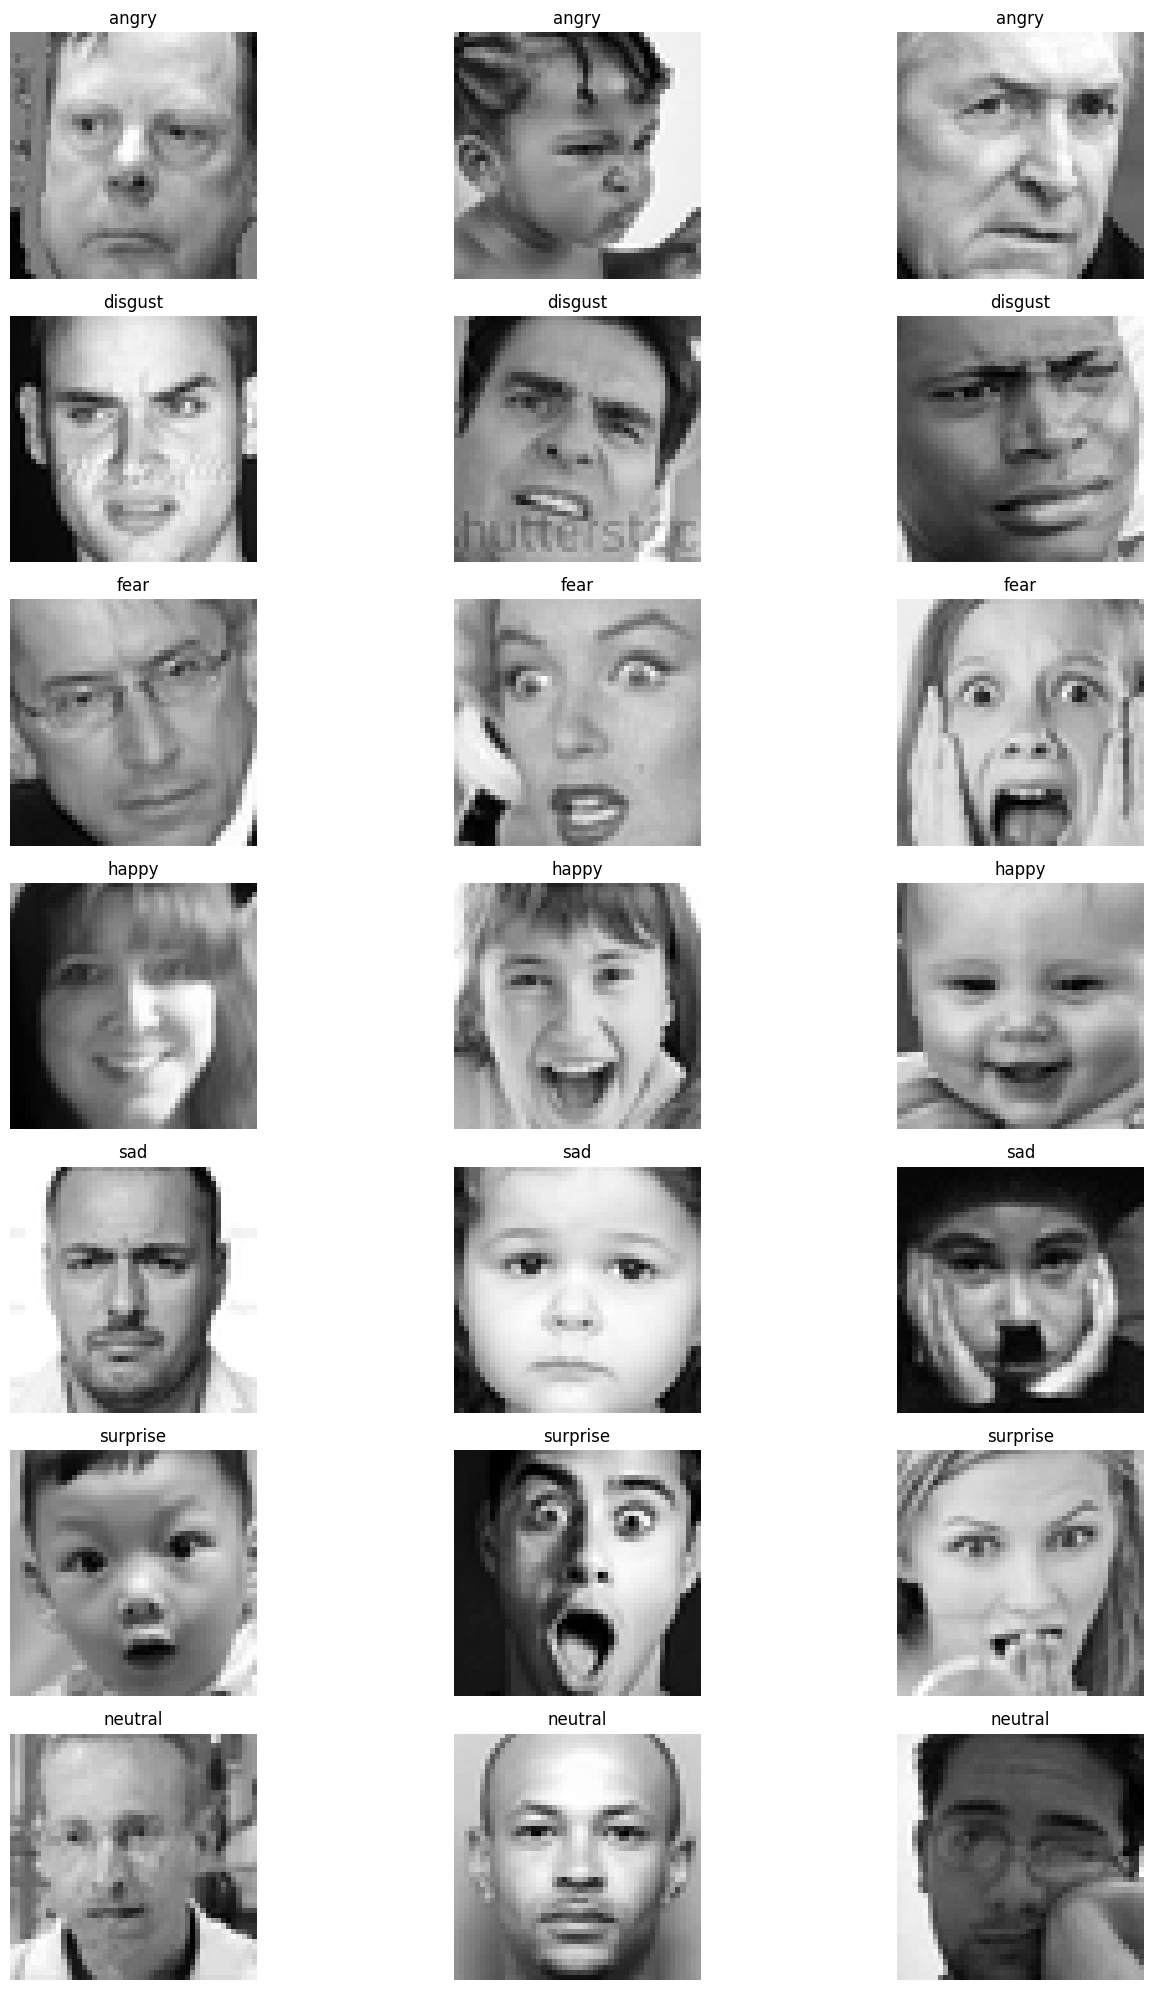

In [ ]:
import random
import matplotlib.pyplot as plt
import torch

# Function to visualize a few sample images from each class
def display_class_samples(data_loader, samples_per_category=3):
  # Define emotion class labels corresponding to their indices
  emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

  # Dictionary to store selected images for each class
  selected_samples = {category: [] for category in range(7)}

  # Collect samples from the provided data loader
  for img_batch, label_batch in data_loader:
    for image, label in zip(img_batch, label_batch):
      label_index = int(label.item())  # Convert tensor label to integer

      # Store image if required samples are not yet collected for this class
      if len(selected_samples[label_index]) < samples_per_category:
        selected_samples[label_index].append(image)

    # Stop once required samples are collected for all classes
    if all(len(img_list) >= samples_per_category for img_list in selected_samples.values()):
      break

  # Create a grid of subplots to display images
  fig, axes = plt.subplots(nrows=7, ncols=samples_per_category, figsize=(15, 20))

  # Iterate over each class and plot images
  for row_idx, category in enumerate(selected_samples):
    for col_idx in range(samples_per_category):
      # Extract image and remove the single-channel dimension
      sample_image = selected_samples[category][col_idx].squeeze()

      # Display the image
      axes[row_idx, col_idx].imshow(sample_image, cmap='gray')
      axes[row_idx, col_idx].set_title(emotion_labels[category])  # Assign class label as title
      axes[row_idx, col_idx].axis('off')  # Hide axis for better visualization

  plt.tight_layout()  # Adjust layout for better spacing
  plt.show()

# Display a few training samples
display_class_samples(train_loader)


# **Task 4**
## Design a custom Convolutional Neural Network (CNN) model with the following properties:
● Use 2 convolutional layers followed by Global Average Pooling (GAP) and a 1x1 convolutional layer for classification.

● Implement residual connections between successive layers, i.e., 2 residual connections, one for each layer.(2M)

● Ensure the architecture is fully convolutional with no fully connected (FC) layer. The FC layer should be replaced by GAP and 1x1 convolution. (1M)

● The number of channels for the 2 layers should be [32,64]. (1M)

● Use Relu as an intermediate activation function and an appropriate output activation
function. (1M)

In [ ]:
class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()

    # Convolutional Layer 1
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv1_residual = nn.Conv2d(1, 32, kernel_size=1)
    self.relu1 = nn.ReLU()

    # Convolutional Layer 2
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv2_residual = nn.Conv2d(32, 64, kernel_size=1)
    self.relu2 = nn.ReLU()

    # Global Average Pooling (GAP) and 1x1 Convolution for Classification
    self.gap = nn.AdaptiveAvgPool2d((1, 1))
    self.conv3 = nn.Conv2d(64, 7, kernel_size=1)  # Output layer for 7 classes

  def forward(self, x):
    # Convolutional Layer 1 with Residual Connection
    residual1 = self.conv1_residual(x)
    x = self.conv1(x)
    x = self.relu1(x + residual1)

    # Convolutional Layer 2 with Residual Connection
    residual2 = self.conv2_residual(x)
    x = self.conv2(x)
    x = self.relu2(x + residual2)

    # Global Average Pooling (GAP) and 1x1 Convolution
    x = self.gap(x)
    x = self.conv3(x)

    return x

# Initialize the model
model = CustomCNN()


# **Task 5**
## Train the custom CNN model using a suitable loss function and the Adam optimizer with alearning rate of 1x 10-3 (1M).
Track the performance by:

● Plotting the training and validation losses against the number of epochs. (2M)

● Ensuring appropriate hyperparameter tuning for optimal performance.

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Epoch 1, Train Loss: 1.7901888653005418, Val Loss: 1.7847304609086778
Epoch 2, Train Loss: 1.7771866079959147, Val Loss: 1.7619267053074308
Epoch 3, Train Loss: 1.7695861839770208, Val Loss: 1.7608337243398031
Epoch 4, Train Loss: 1.7624037130372827, Val Loss: 1.746789230240716
Epoch 5, Train Loss: 1.7549884495862609, Val Loss: 1.7420497099558512
Epoch 6, Train Loss: 1.7478613838852115, Val Loss: 1.7403377658791013
Epoch 7, Train Loss: 1.7428304235759982, Val Loss: 1.731963223218918
Epoch 8, Train Loss: 1.7368601925654508, Val Loss: 1.721876382165485
Epoch 9, Train Loss: 1.7315226647264443, Val Loss: 1.7190521869394515
Epoch 10, Train Loss: 1.7272731586129204, Val Loss: 1.716619567076365


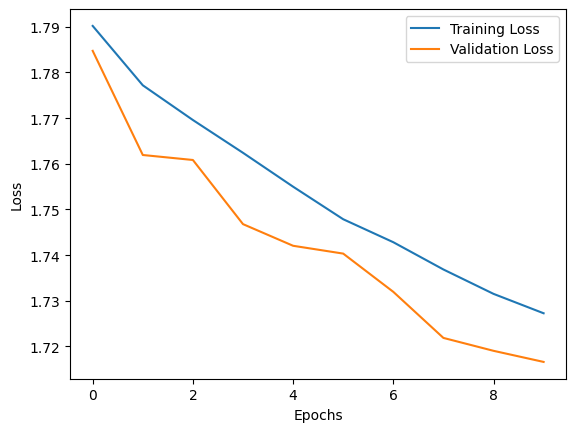

In [ ]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

# Number of epochs
epochs = 10

# Train the model
for epoch in range(epochs):
  # Training loop
  model.train()
  train_loss = 0
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)

  # Validation loop
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      outputs = model(images)
      loss = criterion(outputs.squeeze(), labels)
      val_loss += loss.item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)

  print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## **Task 6**
## Evaluate the trained model on the test set and report the following metrics:
● Accuracy

● Precision

● Recall

● Confusion Matrix

Accuracy: 30.9975%
Precision: 26.7335%
Recall: 24.3827%
Confusion Matrix:
[[  12    0   65  405  228  166   82]
 [   0    0    0   62   15   24   10]
 [   5    0   76  405  173  280   85]
 [   3    0   29 1124  253  231  134]
 [   3    0   40  538  378  145  143]
 [   3    0   44  213   74  429   68]
 [   2    0   55  553  255  162  206]]


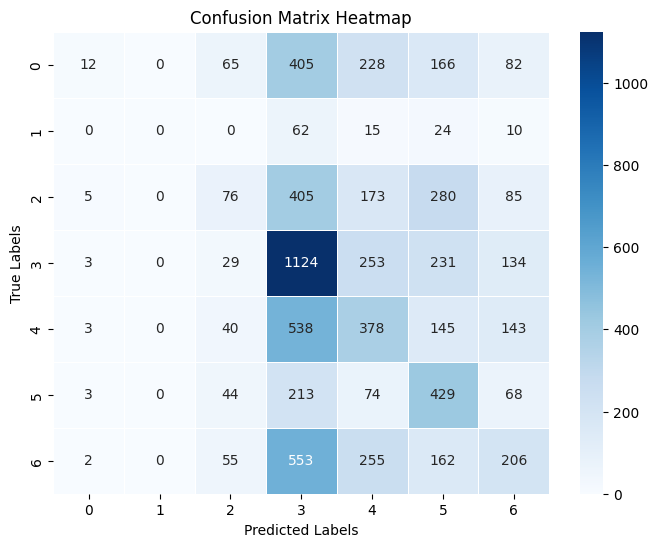

In [ ]:
import warnings
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import torch
import matplotlib.pyplot as plt

# Suppress warnings for a cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
model.eval()

# Lists to store actual labels and predicted labels
test_preds = []
test_labels = []

# Disable gradient calculations for efficiency (no backpropagation needed)
with torch.no_grad():
  for images, labels in test_loader:
    # Forward pass: Get model predictions
    outputs = model(images)

    # Get the predicted class label (highest probability)
    _, predicted = torch.max(outputs.squeeze(), 1)

    # Store predictions and actual labels for later analysis
    test_preds.extend(predicted.cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics
accuracy = accuracy_score(test_labels, test_preds) * 100  # Overall accuracy of the model
precision = precision_score(test_labels, test_preds, average='macro', zero_division=0) * 100  # Precision per class
recall = recall_score(test_labels, test_preds, average='macro', zero_division=0) * 100  # Recall per class

# Generate confusion matrix to analyze misclassifications
cm = confusion_matrix(test_labels, test_preds)

# Print computed metrics
print(f"Accuracy: {accuracy:.4f}%")  # Display accuracy
print(f"Precision: {precision:.4f}%")  # Display precision
print(f"Recall: {recall:.4f}%")  # Display recall
print("Confusion Matrix:")
print(cm)  # Print raw confusion matrix values

# Plot the confusion matrix using a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)

# Label the axes and title for clarity
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")

# Show the plot
plt.show()


# **Task 7**
## Generate Class Activation Maps (CAMs) using Grad-CAM for 1 randomly selected sample from each class. Visualize and analyze the activation regions.

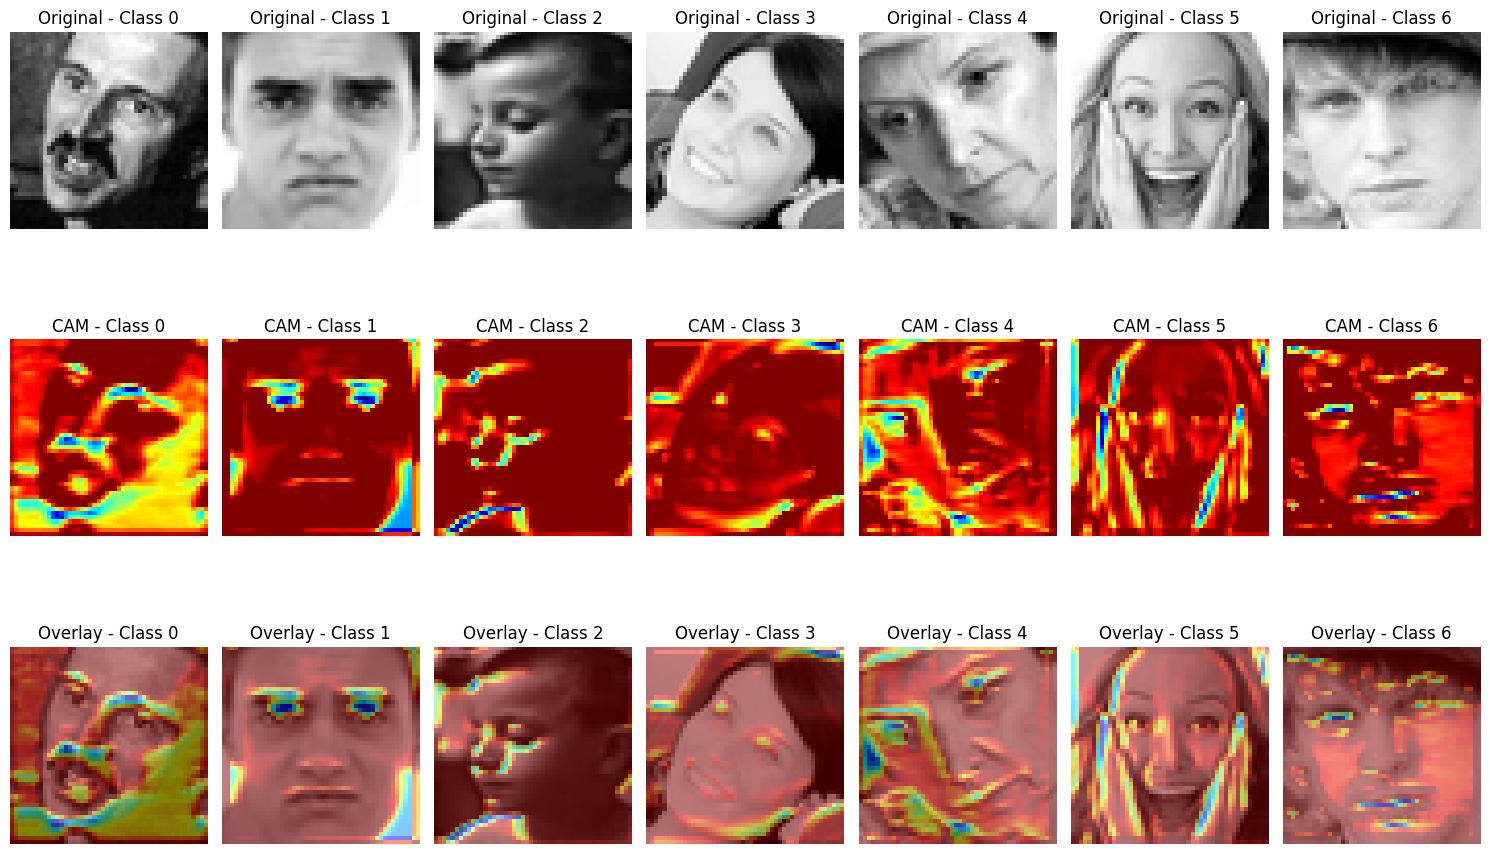

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Class to compute Grad-CAM for a given model and target layer
class GradCAM:
  def __init__(self, model, target_layer):

    self.model = model  # Store model
    self.target_layer = target_layer  # Store target layer
    self.grad_vals = None  # To store gradients
    self.act_maps = None  # To store feature map activations

    # Register hooks to capture activations and gradients
    self.target_layer.register_forward_hook(self.capture_activations)
    self.target_layer.register_backward_hook(self.capture_gradients)

  def capture_activations(self, module, inp, out):

    self.act_maps = out

  def capture_gradients(self, module, grad_inp, grad_out):

    self.grad_vals = grad_out[0]

  def forward(self, img_tensor):

    return self.model(img_tensor)

  def backward(self, model_output):

    self.model.zero_grad()  # Clear previous gradients
    model_output.backward(torch.ones_like(model_output), retain_graph=True)  # Compute gradients

  def generate_cam(self, img_tensor, target_cls=None):

    model_out = self.forward(img_tensor)  # Perform forward pass
    if target_cls is None:
      target_cls = torch.argmax(model_out, dim=1).item()  # Get predicted class if not provided

    self.backward(model_out[:, target_cls])  # Perform backward pass

    # Extract gradients and activations
    grads = self.grad_vals.cpu().data.numpy()[0]
    acts = self.act_maps.cpu().data.numpy()[0]

    # Compute weights by averaging gradients across spatial dimensions
    weights = np.mean(grads, axis=(1, 2))

    # Compute CAM by summing weighted activations
    cam_map = np.zeros(acts.shape[1:], dtype=np.float32)
    for idx, weight in enumerate(weights):
      cam_map += weight * acts[idx]

    # Apply ReLU and normalize the activation map
    cam_map = np.maximum(cam_map, 0)  # ReLU to remove negative values
    cam_map = cv2.resize(cam_map, (img_tensor.shape[2], img_tensor.shape[3]))  # Resize to match input size
    cam_map = (cam_map - np.min(cam_map)) / (np.max(cam_map) - np.min(cam_map) + 1e-10)  # Normalize to [0,1]
    return cam_map


# Function to randomly select one sample per class from the dataset
def select_random_samples(dataset, num_classes=7):

  selected_samples = []  # List to store selected samples
  for cls_idx in range(num_classes):
      # Identify all indices where the label matches the current class
    class_indices = [idx for idx, (_, lbl) in enumerate(dataset) if lbl == cls_idx]
    if len(class_indices) == 0:
      print(f"No samples found for class {cls_idx}. Skipping...")
      continue  # Skip if no samples exist for the class

    rand_idx = np.random.choice(class_indices)  # Randomly choose one index
    selected_samples.append(dataset[rand_idx])  # Append the chosen sample
  return selected_samples


# Function to visualize Grad-CAM results
def display_gradcam_results(model, dataset, target_layer):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
  grad_cam = GradCAM(model, target_layer)  # Initialize GradCAM
  samples = select_random_samples(dataset)  # Select one sample per class

  plt.figure(figsize=(15, 10))  # Set figure size
  for idx, (img, lbl) in enumerate(samples):
    img_tensor = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
    cam_heatmap = grad_cam.generate_cam(img_tensor, target_cls=lbl)  # Generate activation map

    img_arr = img_tensor.squeeze().cpu().numpy()  # Convert tensor to numpy
    img_arr = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))  # Normalize to [0,1]

    # Convert grayscale image to 3 channels if necessary
    if img_arr.ndim == 2:
        img_arr = np.stack((img_arr,) * 3, axis=-1)

    # Apply color map to CAM
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam_heatmap), cv2.COLORMAP_JET)
    cam_heatmap = np.float32(cam_heatmap) / 255  # Normalize to [0,1]

    # Overlay Grad-CAM heatmap on the original image
    blended_image = cv2.addWeighted(np.float32(img_arr), 0.5, cam_heatmap, 0.5, 0)

    # Plot original image
    plt.subplot(3, len(samples), idx + 1)
    plt.imshow(img_arr)
    plt.title(f"Original - Class {lbl}")
    plt.axis('off')

    # Plot CAM heatmap
    plt.subplot(3, len(samples), len(samples) + idx + 1)
    plt.imshow(cam_heatmap)
    plt.title(f"CAM - Class {lbl}")
    plt.axis('off')

    # Plot overlaid image
    plt.subplot(3, len(samples), 2 * len(samples) + idx + 1)
    plt.imshow(blended_image)
    plt.title(f"Overlay - Class {lbl}")
    plt.axis('off')

  plt.tight_layout()  # Adjust spacing between subplots
  plt.show()


# Define the target layer for Grad-CAM analysis
target_layer = model.conv2  # Last convolutional layer in the model

# Generate and visualize Grad-CAM results
display_gradcam_results(model, train_dataset, target_layer)


# **Task 8**
##Implement a targeted Fast Gradient Sign Method (FGSM) adversarial attack to modify test images originally classified as “sad” so that they are misclassified as “happy” by the trained model. (4 M)

## Report the success rate of the attack, which is defined as the fraction of samples that were initially correctly classified as "sad" but misclassified as "happy" after the adversarial perturbation. (1 M)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def iterative_fgsm(img_input, max_perturb, grad_data, target_label, iter_steps=10, step_size=0.01):
  perturbed_img = img_input.clone().detach()  # Create a detached copy of the input image
  perturbed_img.requires_grad = True  # Enable gradient computation

  for _ in range(iter_steps):
    outputs = model(perturbed_img)
    target_labels = torch.tensor([target_label] * outputs.size(0), device=outputs.device, dtype=torch.long)
    loss = F.cross_entropy(outputs.squeeze(), target_labels)
    model.zero_grad()
    loss.backward()

    # Get gradients from perturbed_img
    grad_data = perturbed_img.grad.data

    sign_grad_data = grad_data.sign()
    perturb_amount = -step_size * sign_grad_data
    perturbed_img = perturbed_img + perturb_amount
    perturbed_img = torch.clamp(perturbed_img, 0, 1)
    perturbed_img = perturbed_img.detach()  # Detach to prevent accumulation of gradients
    perturbed_img.requires_grad = True  # Re-enable gradient computation for the next iteration

  return perturbed_img

def targeted_iter_fgsm(model, device, data_loader, max_perturb, target_label, iter_steps=10, step_size=0.01):
  model.eval()  # Set the model to evaluation mode
  initial_correct = 0  # Count of initially correctly classified "sad" images
  attack_success = 0  # Count of successful attacks

  for img_batch, lbl_batch in data_loader:
    img_batch = img_batch.to(device)
    lbl_batch = lbl_batch.to(device)

    # Filter images originally classified as "sad" (class 3)
    sad_img_indices = (lbl_batch == 3).nonzero().squeeze()
    if sad_img_indices.numel() == 0:
      continue  # Skip if no "sad" images in the batch

    sad_imgs = img_batch[sad_img_indices]
    sad_lbls = lbl_batch[sad_img_indices]

    # Ensure sad_imgs requires gradients and is part of the computational graph
    sad_imgs.requires_grad_(True)

    # Forward pass to get the original predictions
    output_preds = model(sad_imgs)
    _, predicted_labels = torch.max(output_preds, 1)

    # Count the number of correctly classified "sad" images
    initial_correct += (predicted_labels == 3).sum().item()

    # Compute the loss for the target class
    target_lbls = torch.full_like(sad_lbls, target_label, dtype=torch.long).to(device)

    # Calculate the loss
    loss = F.cross_entropy(output_preds.squeeze(), target_lbls)

    # Zero all existing gradients
    model.zero_grad()

    # Compute gradients of the loss with respect to the input
    loss.backward()
    grad_data = sad_imgs.grad.data

    # Perform the Iterative FGSM attack
    perturbed_imgs = iterative_fgsm(sad_imgs, max_perturb, grad_data, target_label, iter_steps, step_size)

    # Forward pass on the perturbed images
    output_perturbed = model(perturbed_imgs)
    _, predicted_perturbed = torch.max(output_perturbed, 1)

    # Count the number of successful attacks
    attack_success += (predicted_perturbed == target_label).sum().item()

  # Calculate the success rate
  if initial_correct == 0:
    attack_success_rate = 0.0  # Avoid division by zero
  else:
    attack_success_rate = attack_success / initial_correct

  return attack_success_rate

# Parameters for the Iterative FGSM attack
epsilon_val = 0.1  # Maximum magnitude of the perturbation
target_class_val = 2  # Target class: "happy" (class 2)
iteration_count = 10  # Number of iterations
step_alpha = 0.01  # Step size for each iteration

# Perform the targeted Iterative FGSM attack
device_opt = torch.device("cuda" if torch.cuda.is_available() else "cpu")
success_rate_res = targeted_iter_fgsm(model, device_opt, test_loader, epsilon_val, target_class_val, iteration_count, step_alpha)

# Report the success rate
print(f"Success Rate of Targeted Iterative FGSM Attack: {success_rate_res * 100:.2f}%")


Success Rate of Targeted Iterative FGSM Attack: 39.23%
